In [1]:
from synthetic_data_generator import create_synthetic_matrix, create_synthetic_data
from GNP import GNP, scale_A_by_spectral_radius
from ResGCN import ResGCN
from GMRES import GMRES
from scipy.sparse import csc_matrix, identity
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math

# Hierarchichal training

In our case we can make problem gradually more difficult to solve, while keeping the the `A` matrix in exactly the same shape. This should allow us to use the same `ResGCN`

- First way is to increase the scale of the filter, as the bigger scacle the worse is the conditioning of the matrix. 
- Second is increasing the order of the filer `n`, which makes much more difficult to solve the problem
---

To start we have to generate sythetic problem of given size

In [2]:
Lx = 1000 # Size of domain in km
dxm = 2 # Mesh resolution in km
n2d = np.arange(0, Lx + 1, dxm, dtype="float32").shape[0]**2 # Number of mesh nodes

ss, ii, jj, tri, xcoord, ycoord = create_synthetic_matrix(Lx, dxm, False)
tt = create_synthetic_data(Lx, dxm)

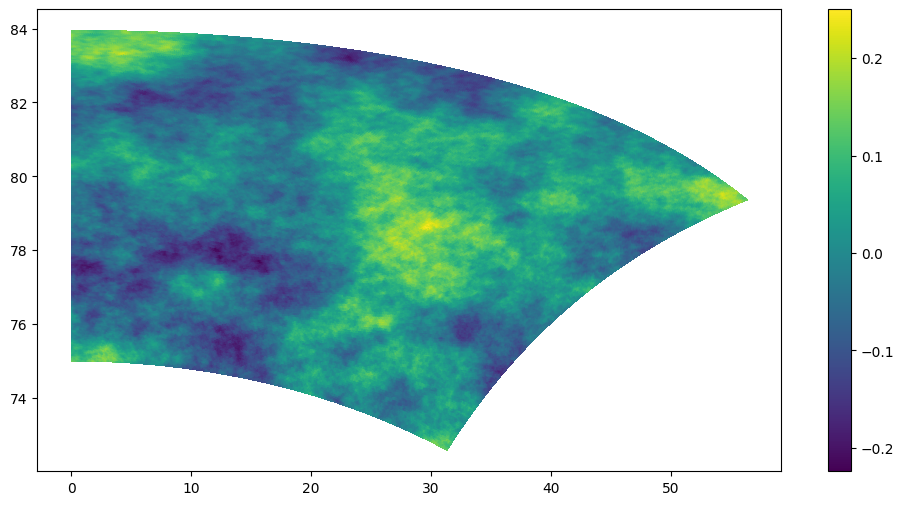

In [3]:
plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

plt.tripcolor(triang, tt)
plt.colorbar()

Now lets define model parameters 

In [43]:
num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.05            # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 2e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 80                      # Krylov subspace dimension for training data
batch_size = 4              # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 1000               # number of epochs in training GNP 

Now we need to create scales that we want to use

In [5]:
kc = 2 * math.pi / np.logspace(1, 3, 10) # 10 values from 10 to 1000 km

In [6]:
tt.shape

(251001,)

Now we define the matricies for model to learn preconditioning

In [18]:
n = 1 # Filter order
device = torch.device("cuda")
solver = GMRES()
As = []

for k in kc: # Looping over the scales
    Smat1 = csc_matrix((ss * (1.0 / np.square(k)), (ii, jj)), shape=(n2d, n2d))
    Smat = identity(n2d) + 2.0 * (Smat1 ** n)
    A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)
    A = scale_A_by_spectral_radius(A)
    As += [A]
    
data = torch.tensor(np.array(tt), device=device, dtype=torch.float64)

Now model can be initialized for the first phase of training

In [44]:
net = ResGCN(As[-1], num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

As a test we will solve the problem without preconditioner 

In [23]:
iterations = np.zeros(len(As))

for i in range(len(As)):
    ttw = data - As[i] @ data  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=20000, progress_bar=False)
    print("Iteration " + str(iters))
    iterations[i] = iters

Iteration 140
Iteration 350
Iteration 915
Iteration 2528
Iteration 7125
Iteration 19718


KeyboardInterrupt: 

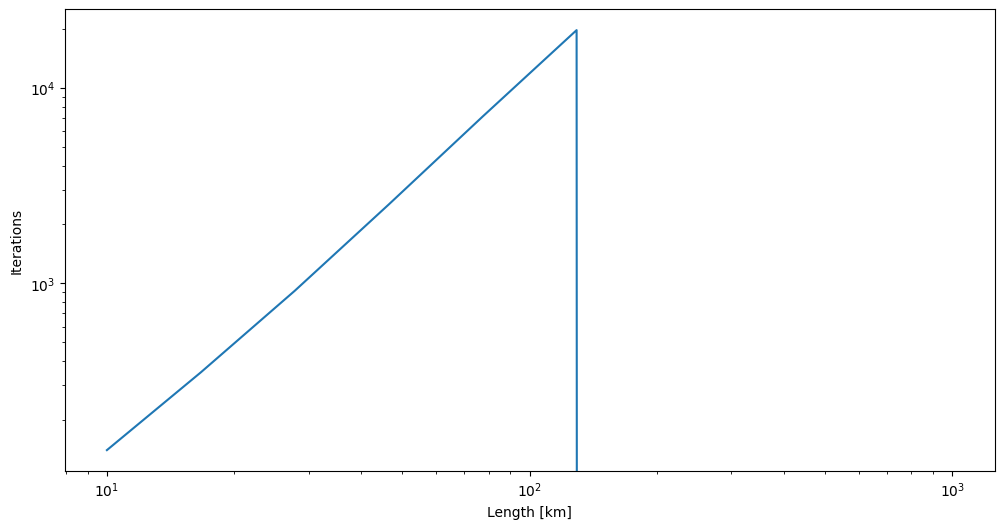

In [27]:
plt.plot(np.logspace(1, 3, 10), iterations)
plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")

Now we can only solver problems up to 200 km. Now we run first phase of training 

In [45]:
import time 

tic = time.time()
hist_loss, best_loss, best_epoch, model_file = M.train(
    batch_size, grad_accu_steps, epochs, optimizer, scheduler, num_workers=4,
    checkpoint_prefix_with_path="./tmp_", progress_bar=False)
M.net.load_state_dict(torch.load(f"./tmp_epoch_{best_epoch}.pt", map_location=device, weights_only=True))

print(f'Done. Training time: {time.time()-tic} seconds')
print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')

Done. Training time: 115.85863661766052 seconds
Loss: inital = 0.10165906240810123, final = 0.011233970541507076, best = 0.010839790983007958, epoch = 981


With preconditioner for the sample problem

In [ ]:
iterations_pre = np.zeros(len(As))

for i in range(len(As)):
    ttw = data - As[i] @ data  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=20000, progress_bar=False, M=M)
    print("Iteration " + str(iters))
    iterations_pre[i] = iters

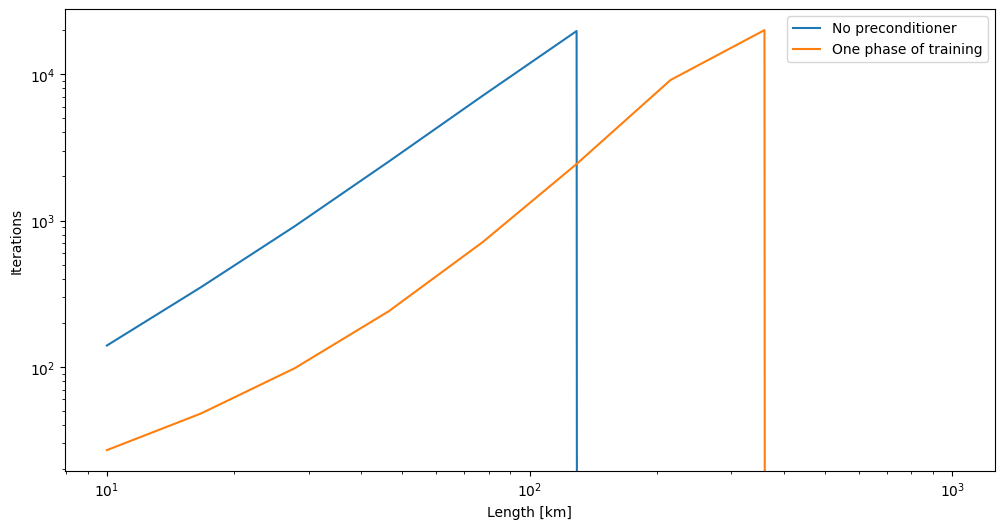

In [47]:
plt.plot(np.logspace(1, 3, 10), iterations, label="No preconditioner")
plt.plot(np.logspace(1, 3, 10), iterations_pre, label="One phase of training")

plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()
    

Not great, not terrible. Now let's try training for larger scales, but we reduce amount of time we spend on each case

In [49]:
! rm ./*.pt

/home/a/a270225/.conda/envs/env-name/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


I reduced number of epochs so the total training budget is the same as for 1 phase

In [50]:
net = ResGCN(As[0], num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

for A in As: 
    M.A = A
    hist_loss, best_loss, best_epoch, model_file = M.train(
    batch_size, grad_accu_steps, epochs // 10, optimizer, scheduler, num_workers=4, 
    checkpoint_prefix_with_path="./tmp_", progress_bar=False)
    M.net.load_state_dict(torch.load(f"./tmp_epoch_{best_epoch}.pt", map_location=device, weights_only=True))
    print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')
    

Loss: inital = 0.10385292914161467, final = 0.018677796417757308, best = 0.017226051265428196, epoch = 93
Loss: inital = 0.017809010481401922, final = 0.014873276742102452, best = 0.014662079066970445, epoch = 92
Loss: inital = 0.015077653029206438, final = 0.01776585921584246, best = 0.013627624689164515, epoch = 74
Loss: inital = 0.014288291637348032, final = 0.014048194082699127, best = 0.013264181350412544, epoch = 72
Loss: inital = 0.013319472220265019, final = 0.013424918818633202, best = 0.012601258403057421, epoch = 60
Loss: inital = 0.01265509303930705, final = 0.013441714480555268, best = 0.01263629771729297, epoch = 83
Loss: inital = 0.012864868218918924, final = 0.012377797263060172, best = 0.011813133511495282, epoch = 87
Loss: inital = 0.0121587356516862, final = 0.012254733687860248, best = 0.011779618529497464, epoch = 76
Loss: inital = 0.01201951656306416, final = 0.012982588224821219, best = 0.011201305563228377, epoch = 90
Loss: inital = 0.0133151663320002, final = 0

In [51]:
iterations_post = np.zeros(len(As))

for i in range(len(As)):
    ttw = data - As[i] @ data  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=20000, progress_bar=False, M=M)
    print("Iteration " + str(iters))
    iterations_post[i] = iters

Iteration 27
Iteration 47
Iteration 94
Iteration 214
Iteration 590
Iteration 1857
Iteration 5830
Iteration 19815


KeyboardInterrupt: 

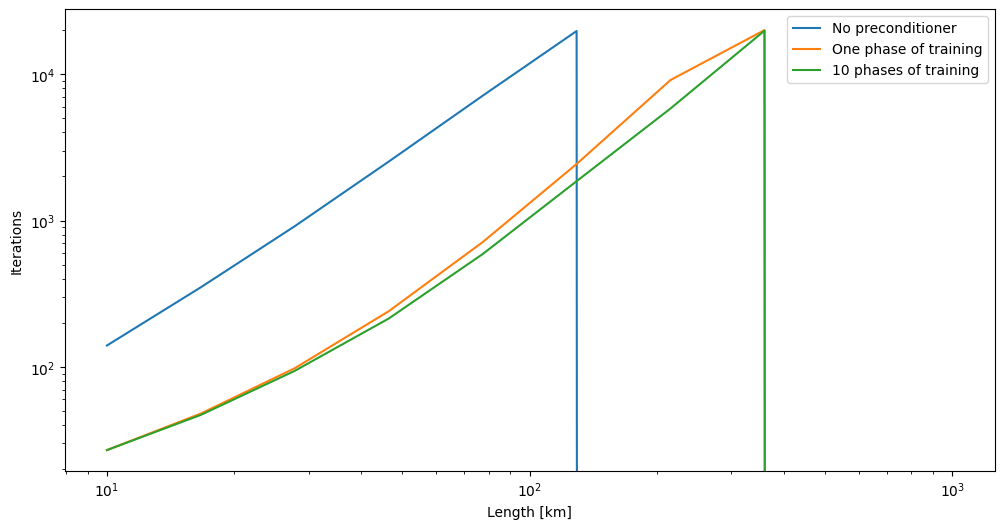

In [52]:
plt.plot(np.logspace(1, 3, 10), iterations, label="No preconditioner")
plt.plot(np.logspace(1, 3, 10), iterations_pre, label="One phase of training")
plt.plot(np.logspace(1, 3, 10), iterations_post, label="10 phases of training")

plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()